In [3]:
# define the path of the data and project
proj_path = 'D:/VScode/MRes/Clustering_under_the_ice/'
data_path = 'D:/VScode/MRes/scienceweb.whoi.edu/itp/data/'

In [6]:
#download zip data

import requests
from bs4 import BeautifulSoup
import os

'''get the filename list for files end with 'final.tar.Z' from the url'''
def get_webfile_name(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    file_name = []
    for link in soup.find_all('a'):
        if link.get('href').endswith('final.tar.Z'):
            file_name.append(link.get('href'))
    return file_name

url = 'https://scienceweb.whoi.edu/itp/data/'
file_name = get_webfile_name(url)

# file_name = [name.replace('_1', '') if '_1final.tar.Z' in name else name for name in file_name]

# check whether files on the online website exist in the data folder
def check_file(file_name):
    not_downloaded_files = []
    for i in file_name:
        file_path = os.path.join(data_path, i)
        if not os.path.exists(file_path):
            not_downloaded_files.append(i)
    return not_downloaded_files

file_name = check_file(file_name)

#download the files if the file_name list is not empty
def download_file(file_name,url):
    os.chdir(data_path)
    for i in file_name:
        file_url = url + i
        print(f' File {i} does not exist. Downloading...')
        response = requests.get(file_url)
        with open(i, 'wb') as f:
            f.write(response.content)
    os.chdir(proj_path)
    print('Download complete')

if len(file_name) > 0:
    download_file(file_name,url)
else:
    print('All .tar.Z files exist')

 File itp39_1final.tar.Z does not exist. Downloading...
Download complete


In [9]:
# readname the tar.Z files with _1 in the name
if os.path.exists(data_path+'/itp39_1final.tar.Z'):
    if os.path.exists(data_path+'/itp39final.tar.Z'):
        os.remove(data_path+'/itp39final.tar.Z')
    else:
        os.rename(data_path+'/itp39_1final.tar.Z', data_path+'/itp39final.tar.Z')
        print('rename itp39_1final.tar.Z to itp39final.tar.Z')
else:
    print('itp39_1final.tar.Z does not exist')

rename itp39_1final.tar.Z to itp39final.tar.Z


In [35]:
!pip install pyunpack

In [53]:
!pip install patool

     ---------------------------------------- 77.5/77.5 kB 4.2 MB/s eta 0:00:00


In [10]:
import os
from pyunpack import Archive
import re

# Define a set to keep track of the sensor numbers of the .dat files that have been extracted
extracted_sensors = set()

# Loop over all the .dat files in the data directory to get the list of extracted sensor numbers
for file in os.listdir(data_path):
    if file.endswith('.dat'):
        # Extract the sensor number from the file name
        sensor_num = file.split('itp')[1]
        sensor_num=re.split(r'\D+', sensor_num)[0]
        extracted_sensors.add(sensor_num)

# Extract the .tar.Z files if they are not on the extracted_sensors list
counter=0
for file in os.listdir(data_path):
    if file.endswith('.tar.Z'):
        # Extract the sensor number from the file name
        sensor_num = file.split('final')[0][3:]
        if sensor_num not in extracted_sensors:
            counter=counter+1
            try:
                # Extract the .tar.Z file
                Archive(os.path.join(data_path, file)).extractall(data_path)
                print(f'extrating {file}...')
                # Add the extracted sensor number to the extracted_sensors set
                extracted_sensors.add(sensor_num)
                
            except Exception as e:
                print(f"Error extracting {file}: {e}")
if counter==0:
    print('All files been extracted')


All files been extracted


In [99]:
import pandas as pd
import numpy as np
import xarray as xr

# create a pandas dataframe to store the data
df = pd.DataFrame(columns=['profiler', 'right_format','larger_1','date', 'lon', 'lat', 'p_start','p_end','p_len', 'is_oxy', 'oxy_len'])

import glob
files = glob.glob(f'{data_path}/*.dat')

counter=0
for file in files:
    with open(file) as infile:
        metadata_names=infile.readline()
        metadata_vals=infile.readline().split()
    df.loc[counter, 'profiler'] = metadata_names.split(':')[0].split(',')[0].split(' ')[1]
    if metadata_vals[-1].isnumeric():
        df.loc[counter, 'right_format'] = 1
        if int(metadata_vals[-1])>1:
            # print(f'normal {metadata_vals[-1]}')
            df.loc[counter, 'larger_1'] = 1
            ind=pd.read_csv(file,sep='\s+',header=2,engine='python',skipfooter=1,index_col=0)
            try:
                ds=ind.to_xarray().rename({'%pressure(dbar)':'pressure','temperature(C)':'temperature'})
                ds = xr.Dataset({'pressure': ds['pressure'],'temperature': ds['temperature'],'salinity':ds['salinity']})
            except ValueError:
                print('cannot convert to xarray')

            ds=ds.assign_coords({'profiler':int(metadata_names.split(':')[0].split(',')[0].split(' ')[1]),
                                 'date':np.datetime64(pd.Timestamp(metadata_vals[0])+pd.Timedelta(float(metadata_vals[1]),'D')),
                                  'lon':float(metadata_vals[2]),
                                  'lat':float(metadata_vals[3])}
                                 )
            ds=ds.drop_duplicates('pressure',keep='last')
            df.loc[counter, 'date'] = ds.date.values
            df.loc[counter, 'lon'] = ds.lon.values
            df.loc[counter, 'lat'] = ds.lat.values
            # get the first non-nan pressure value
            df.loc[counter, 'p_start'] = ds.pressure.values[~np.isnan(ds.pressure.values)][0]
            # get the last non-nan pressure value
            df.loc[counter, 'p_end'] = ds.pressure.values[~np.isnan(ds.pressure.values)][-1]
            # get the length of the pressure array
            df.loc[counter, 'p_len'] = len(ds.pressure.values)

            if len(ds.pressure.values)<=1:#ds.pressure.size<=1:
                df.loc[counter, 'larger_1'] = 0
            if 'dissolved_oxygen' in ds:
                df.loc[counter,'is_oxy'] = 1
                # get the length of the oxygen array
                df.loc[counter, 'oxy_len'] = len(ds.dissolved_oxygen.values)
            else:
                df.loc[counter,'is_oxy'] = 0
        else:
            # print(f'not normal{metadata_vals[-1]}')
            df.loc[counter, 'larger_1'] = 0
            ind=pd.read_csv(file,sep='\s+',header=2,engine='python',skipfooter=1,index_col=0)
            try:
                ds=ind.to_xarray().rename({'%pressure(dbar)':'pressure','temperature(C)':'temperature'})
                ds = xr.Dataset({'pressure': ds['pressure'],'temperature': ds['temperature'],'salinity':ds['salinity']})
            except ValueError:
                print('cannot convert to xarray')

            ds=ds.assign_coords({'profiler':int(metadata_names.split(':')[0].split(',')[0].split(' ')[1]),
                                 'date':np.datetime64(pd.Timestamp(metadata_vals[0])+pd.Timedelta(float(metadata_vals[1]),'D')),
                                  'lon':float(metadata_vals[2]),
                                  'lat':float(metadata_vals[3])}
                                 )
            ds=ds.drop_duplicates('pressure',keep='last')
            df.loc[counter, 'date'] = ds.date.values
            df.loc[counter, 'lon'] = ds.lon.values
            df.loc[counter, 'lat'] = ds.lat.values
    else:
        print(f'not numeric {metadata_vals[-1]}')
        df.loc[counter, 'right_format'] = 0
    
    # counter += 1
    # if counter==1000:
    #     break


not numeric salinity
cannot convert to xarray
not numeric salinity
not numeric salinity


KeyboardInterrupt: 

In [90]:
df

,profiler,right_format,larger_1,date,lon,lat,p_start,p_end,p_len,is_oxy,oxy_len
0,100,1,1,2017-09-20T00:02:04.416000000,-149.1544,80.0378,8.4,789.0,782,0,NaN
1,100,1,1,2017-09-20T06:02:01.824000000,-149.1395,80.069,34.3,761.0,728,0,NaN
2,100,1,1,2017-09-21T00:02:02.688000000,-148.7704,80.0992,8.3,760.6,754,0,NaN
3,100,1,1,2017-09-21T06:02:02.687999000,-148.5921,80.1193,32.1,760.7,730,0,NaN
4,100,1,1,2017-09-22T00:02:02.688000000,-147.9601,80.1768,8.5,752.0,745,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
995,102,1,1,2019-11-04T01:17:04.992000000,121.7631,86.0891,4.9,6.2,2,0,NaN
996,102,1,0,2019-11-04T01:32:06.144000000,121.753,86.0898,NaN,NaN,NaN,NaN,NaN
997,102,1,0,2019-11-04T02:47:04.992000000,121.7063,86.0933,NaN,NaN,NaN,NaN,NaN
998,102,1,1,2019-11-04T03:02:01.824000000,121.6972,86.094,4.9,251.2,247,0,NaN


In [91]:
# write df to csv
df.to_csv(f'{data_path}/df.csv',index=False)

In [92]:
# read the df from local file
df = pd.read_csv(f'{data_path}/df.csv')


In [93]:
df

,profiler,right_format,larger_1,date,lon,lat,p_start,p_end,p_len,is_oxy,oxy_len
0,100,1,1,2017-09-20T00:02:04.416000000,-149.1544,80.0378,8.4,789.0,782.0,0.0,NaN
1,100,1,1,2017-09-20T06:02:01.824000000,-149.1395,80.0690,34.3,761.0,728.0,0.0,NaN
2,100,1,1,2017-09-21T00:02:02.688000000,-148.7704,80.0992,8.3,760.6,754.0,0.0,NaN
3,100,1,1,2017-09-21T06:02:02.687999000,-148.5921,80.1193,32.1,760.7,730.0,0.0,NaN
4,100,1,1,2017-09-22T00:02:02.688000000,-147.9601,80.1768,8.5,752.0,745.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
995,102,1,1,2019-11-04T01:17:04.992000000,121.7631,86.0891,4.9,6.2,2.0,0.0,NaN
996,102,1,0,2019-11-04T01:32:06.144000000,121.7530,86.0898,NaN,NaN,NaN,NaN,NaN
997,102,1,0,2019-11-04T02:47:04.992000000,121.7063,86.0933,NaN,NaN,NaN,NaN,NaN
998,102,1,1,2019-11-04T03:02:01.824000000,121.6972,86.0940,4.9,251.2,247.0,0.0,NaN


In [95]:
# print the number of profiles not has right format, the number of profiles with pressure length less than or equals to 1, and the number of profiles with oxygen data
print(f'Number of profiles not has right format: {len(df[df.right_format==0])}')
print(f'Number of profiles with pressure length less than or equals to 1: {len(df[df.larger_1==0])}')
print(f'Number of profiles with oxygen data: {len(df[df.is_oxy==1])}')

Number of profiles not has right format: 0
Number of profiles with pressure length less than or equals to 1: 174
Number of profiles with oxygen data: 0


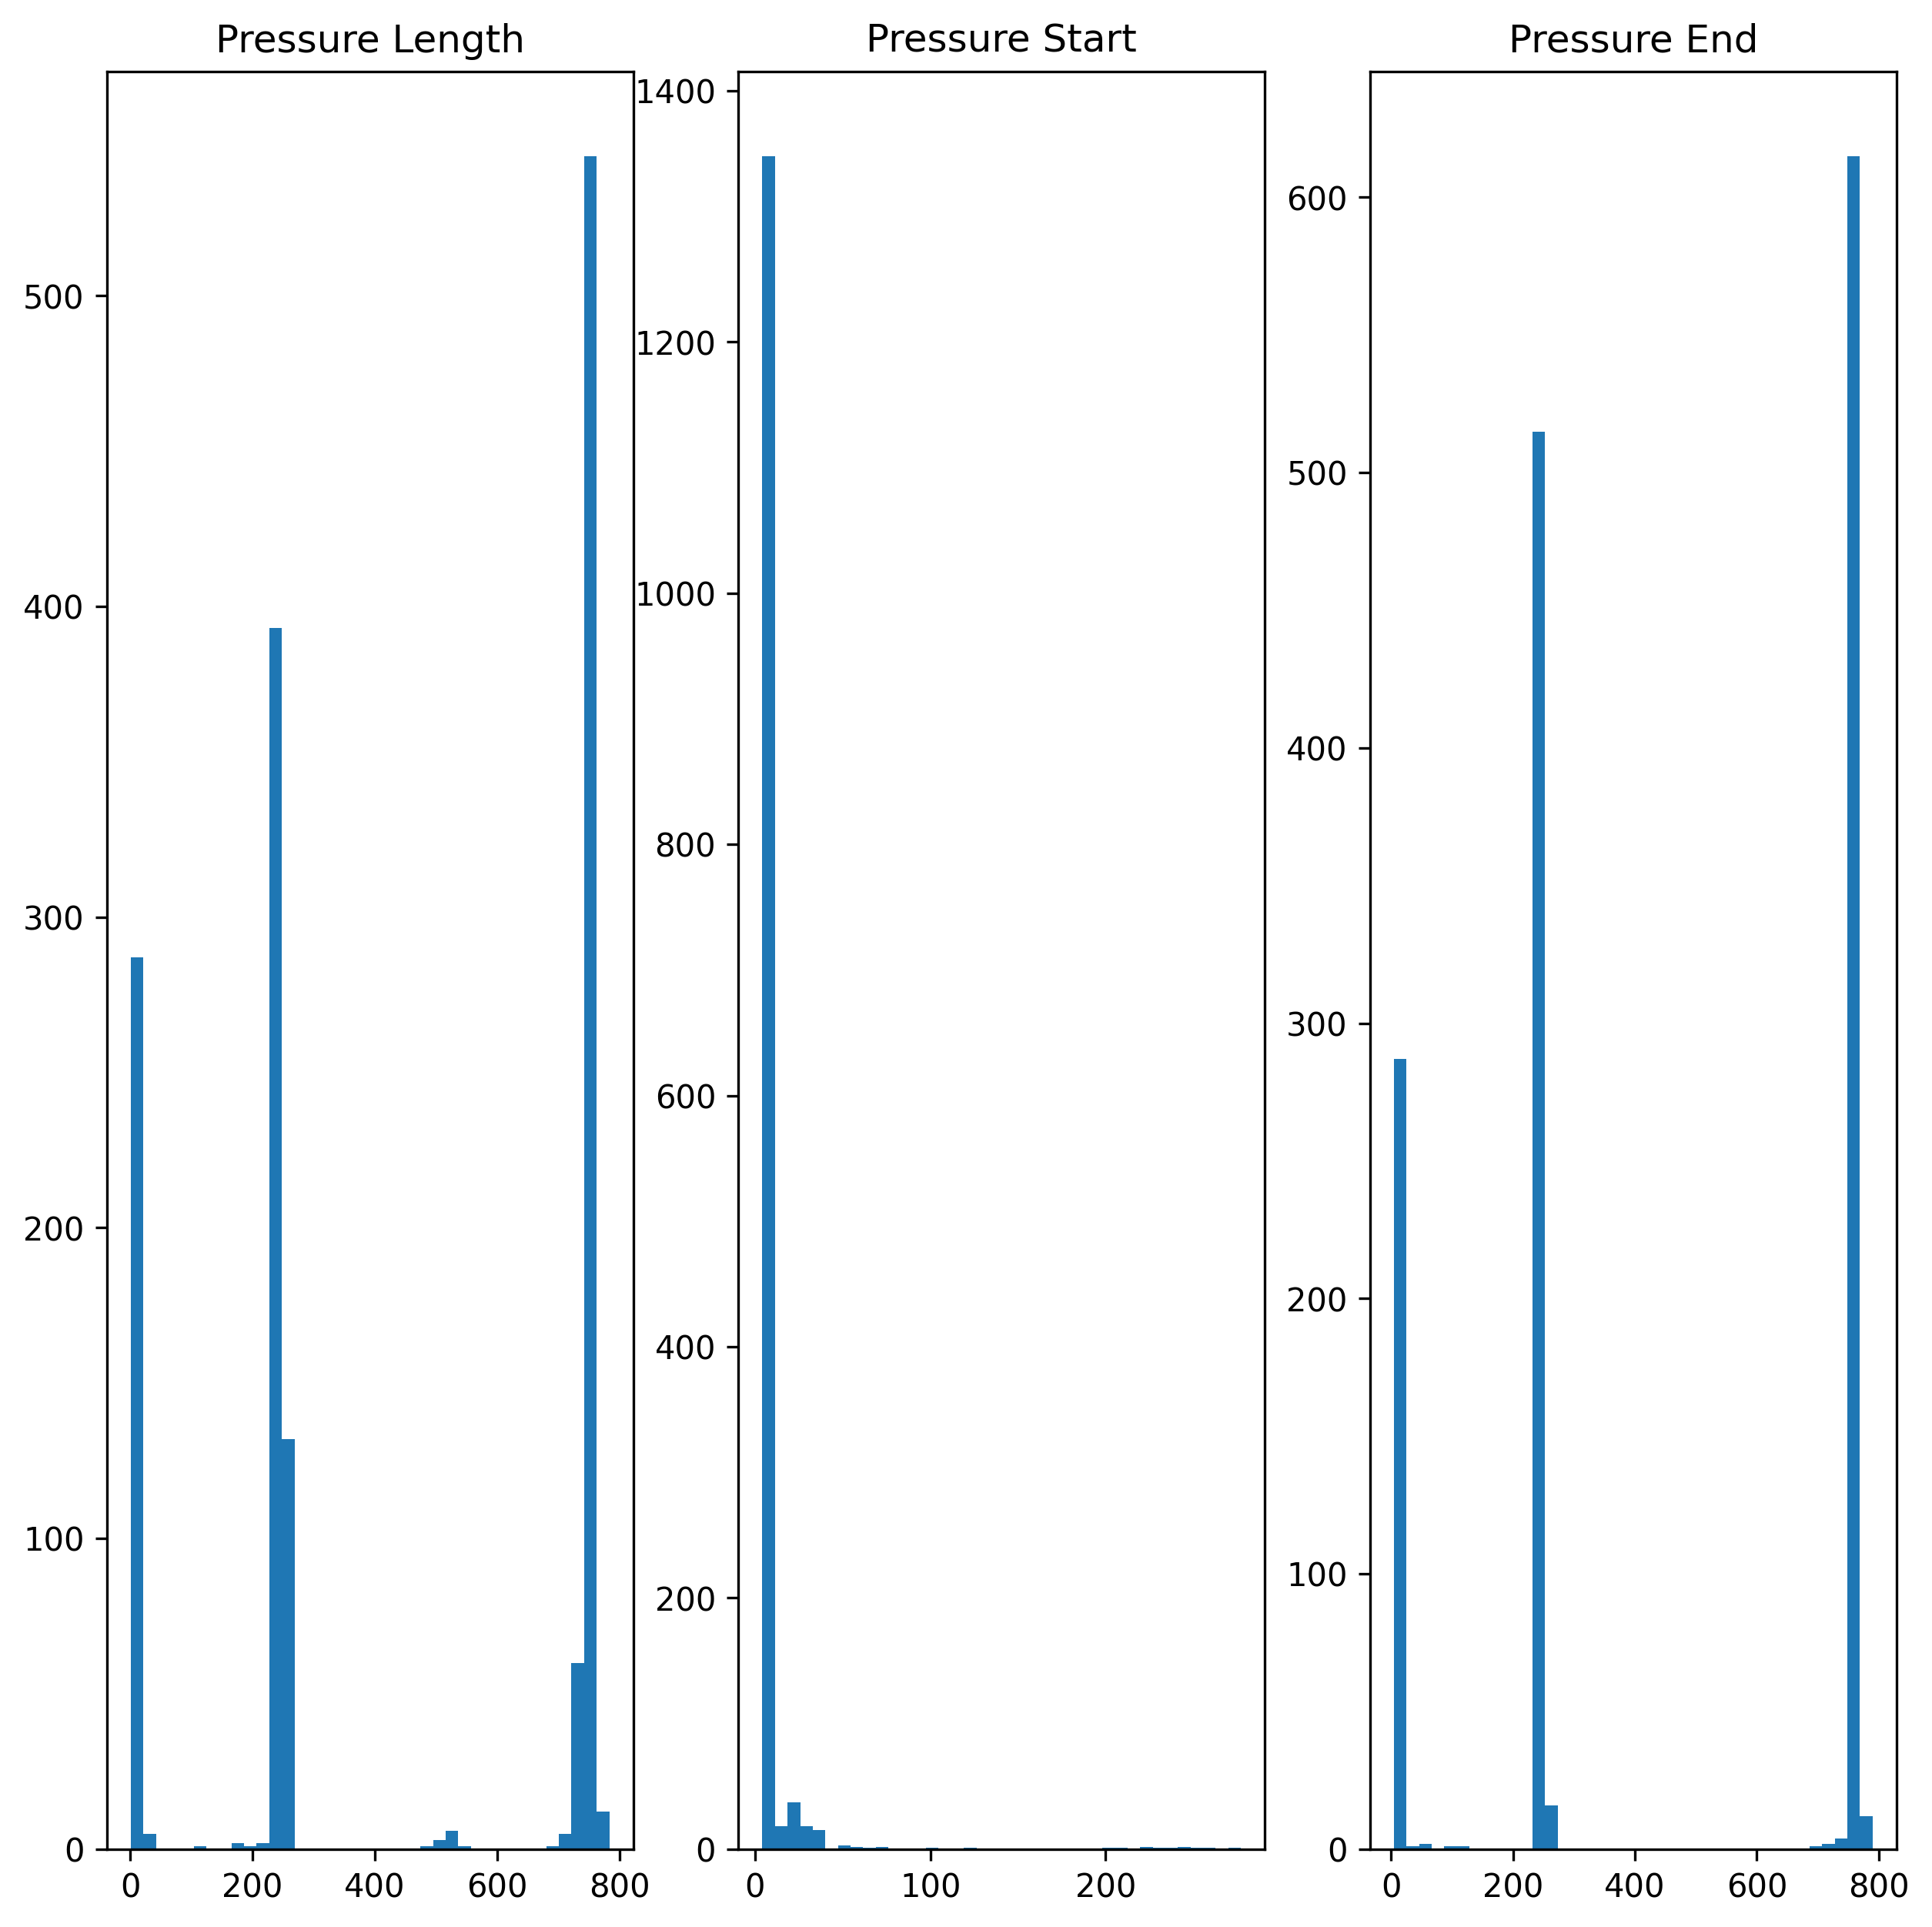

In [46]:
import matplotlib.pyplot as plt

# plot the histogram of the pressure length, pressure start, and pressure end if the value in the row is not nan using subplots with the number of bins adjusted according to the length of the data
fig, axs = plt.subplots(1, 3, figsize=(10, 10),dpi=300)
axs[0].hist(df[df.p_len.notnull()].p_len, bins=int(np.sqrt(len(df[df.p_len.notnull()].p_len))))
axs[0].set_title('Pressure Length')
axs[1].hist(df[df.p_start.notnull()].p_start, bins=int(np.sqrt(len(df[df.p_start.notnull()].p_start))))
axs[1].set_title('Pressure Start')
axs[2].hist(df[df.p_end.notnull()].p_end, bins=int(np.sqrt(len(df[df.p_end.notnull()].p_end))))
axs[2].set_title('Pressure End')
plt.show()



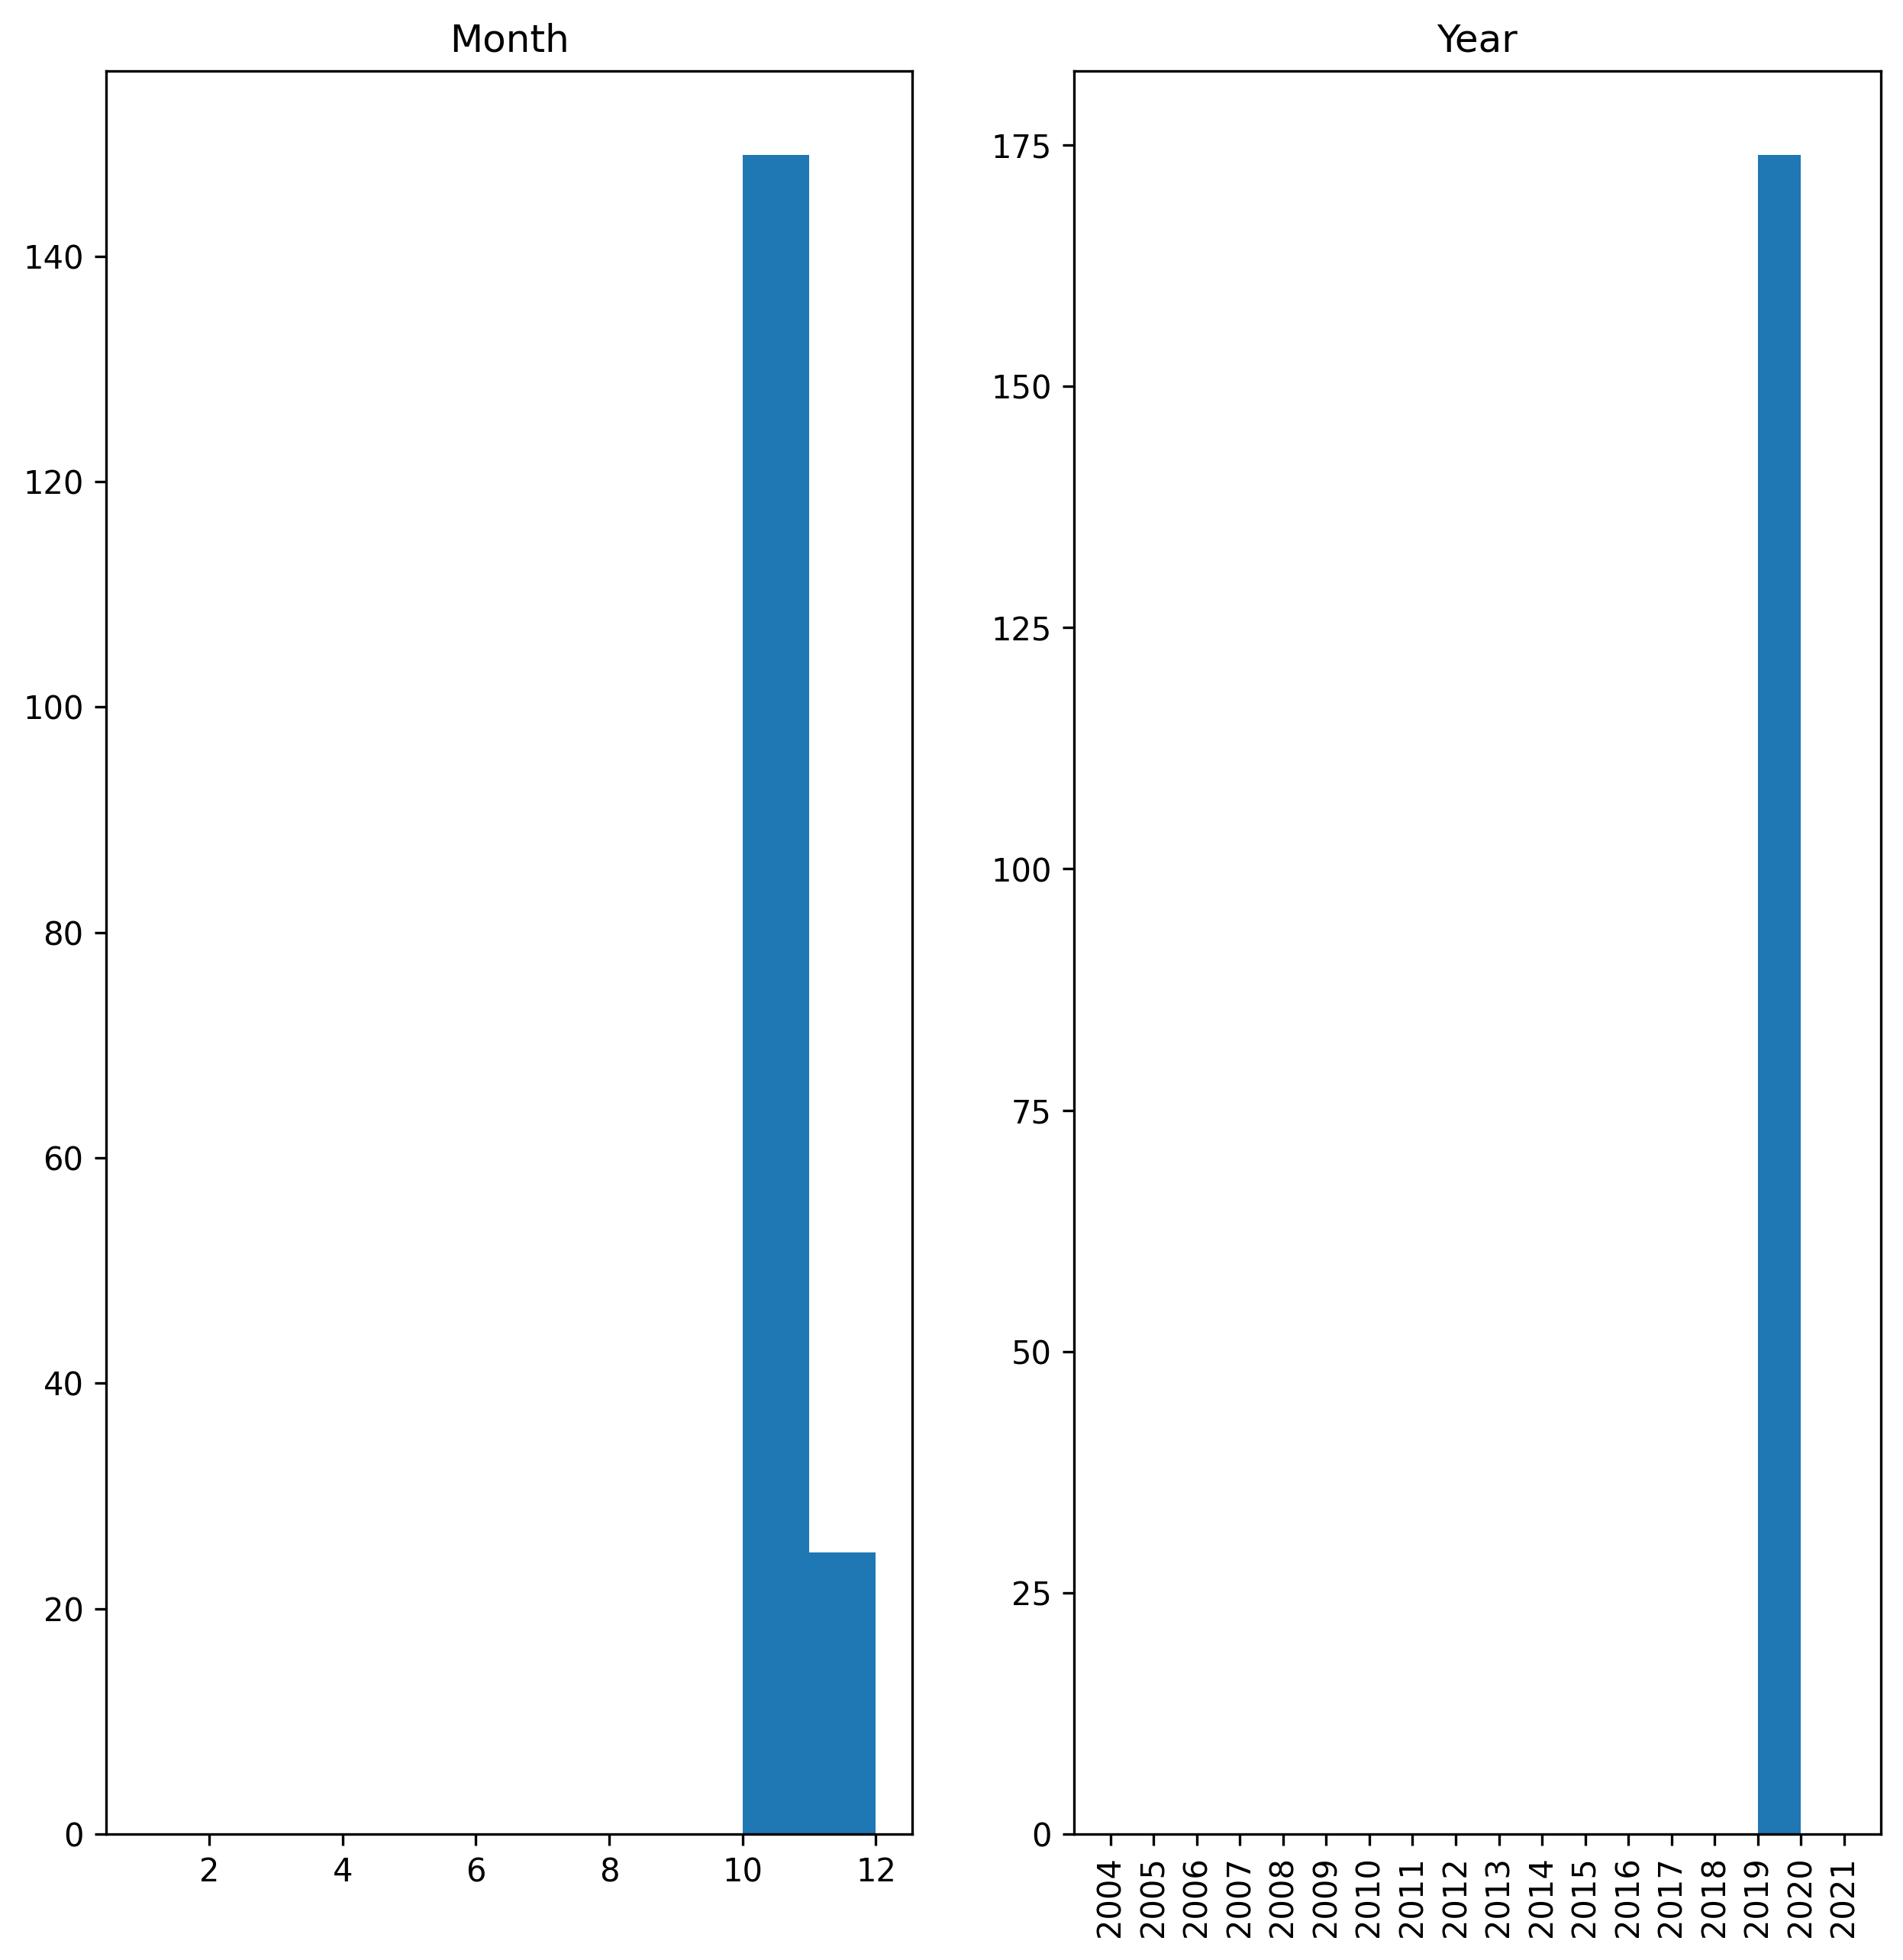

In [67]:
# if there are profiles with pressure length less than 1, plot histogram of the month and year of those profiles side by side
if len(df[df.larger_1==0])>0:

    # covert the df.date to datetime
    df.date = pd.to_datetime(df.date)
    years = df[df.larger_1==0].date.dt.year.values
    months = df[df.larger_1==0].date.dt.month.values

    fig, axs = plt.subplots(1, 2, figsize=(10, 10),dpi=300)
    bins_month = np.arange(1, 13)  # set bin edges
    axs[0].hist(df[df.larger_1==0].date.dt.month.values, bins=bins_month)
    axs[0].set_title('Month')
    bins_year = np.arange(2004, 2022)  # set bin edges
    axs[1].hist(df[df.larger_1==0].date.dt.year.values, bins=bins_year)
    axs[1].set_xticks(bins_year)
    axs[1].set_xticklabels(bins_year, rotation=90) # rotate xticklabels by 90 degrees
    axs[1].set_title('Year')
    plt.show()

In [69]:
# if there is oxygen data, plot the distribution of the oxygen length using a histogram, and the date of the profiles with oxygen data side by side
if len(df[df.is_oxy == 1]) > 0:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5),dpi=300)
    ax[0].hist(df[df.is_oxy == 1].oxy_len, bins=50)
    ax[0].set_title('Oxygen Length')
    ax[1].hist(df[df.is_oxy == 1].date, bins=50)
    ax[1].set_title('Date of Profiles with Oxygen Data')
    plt.show()

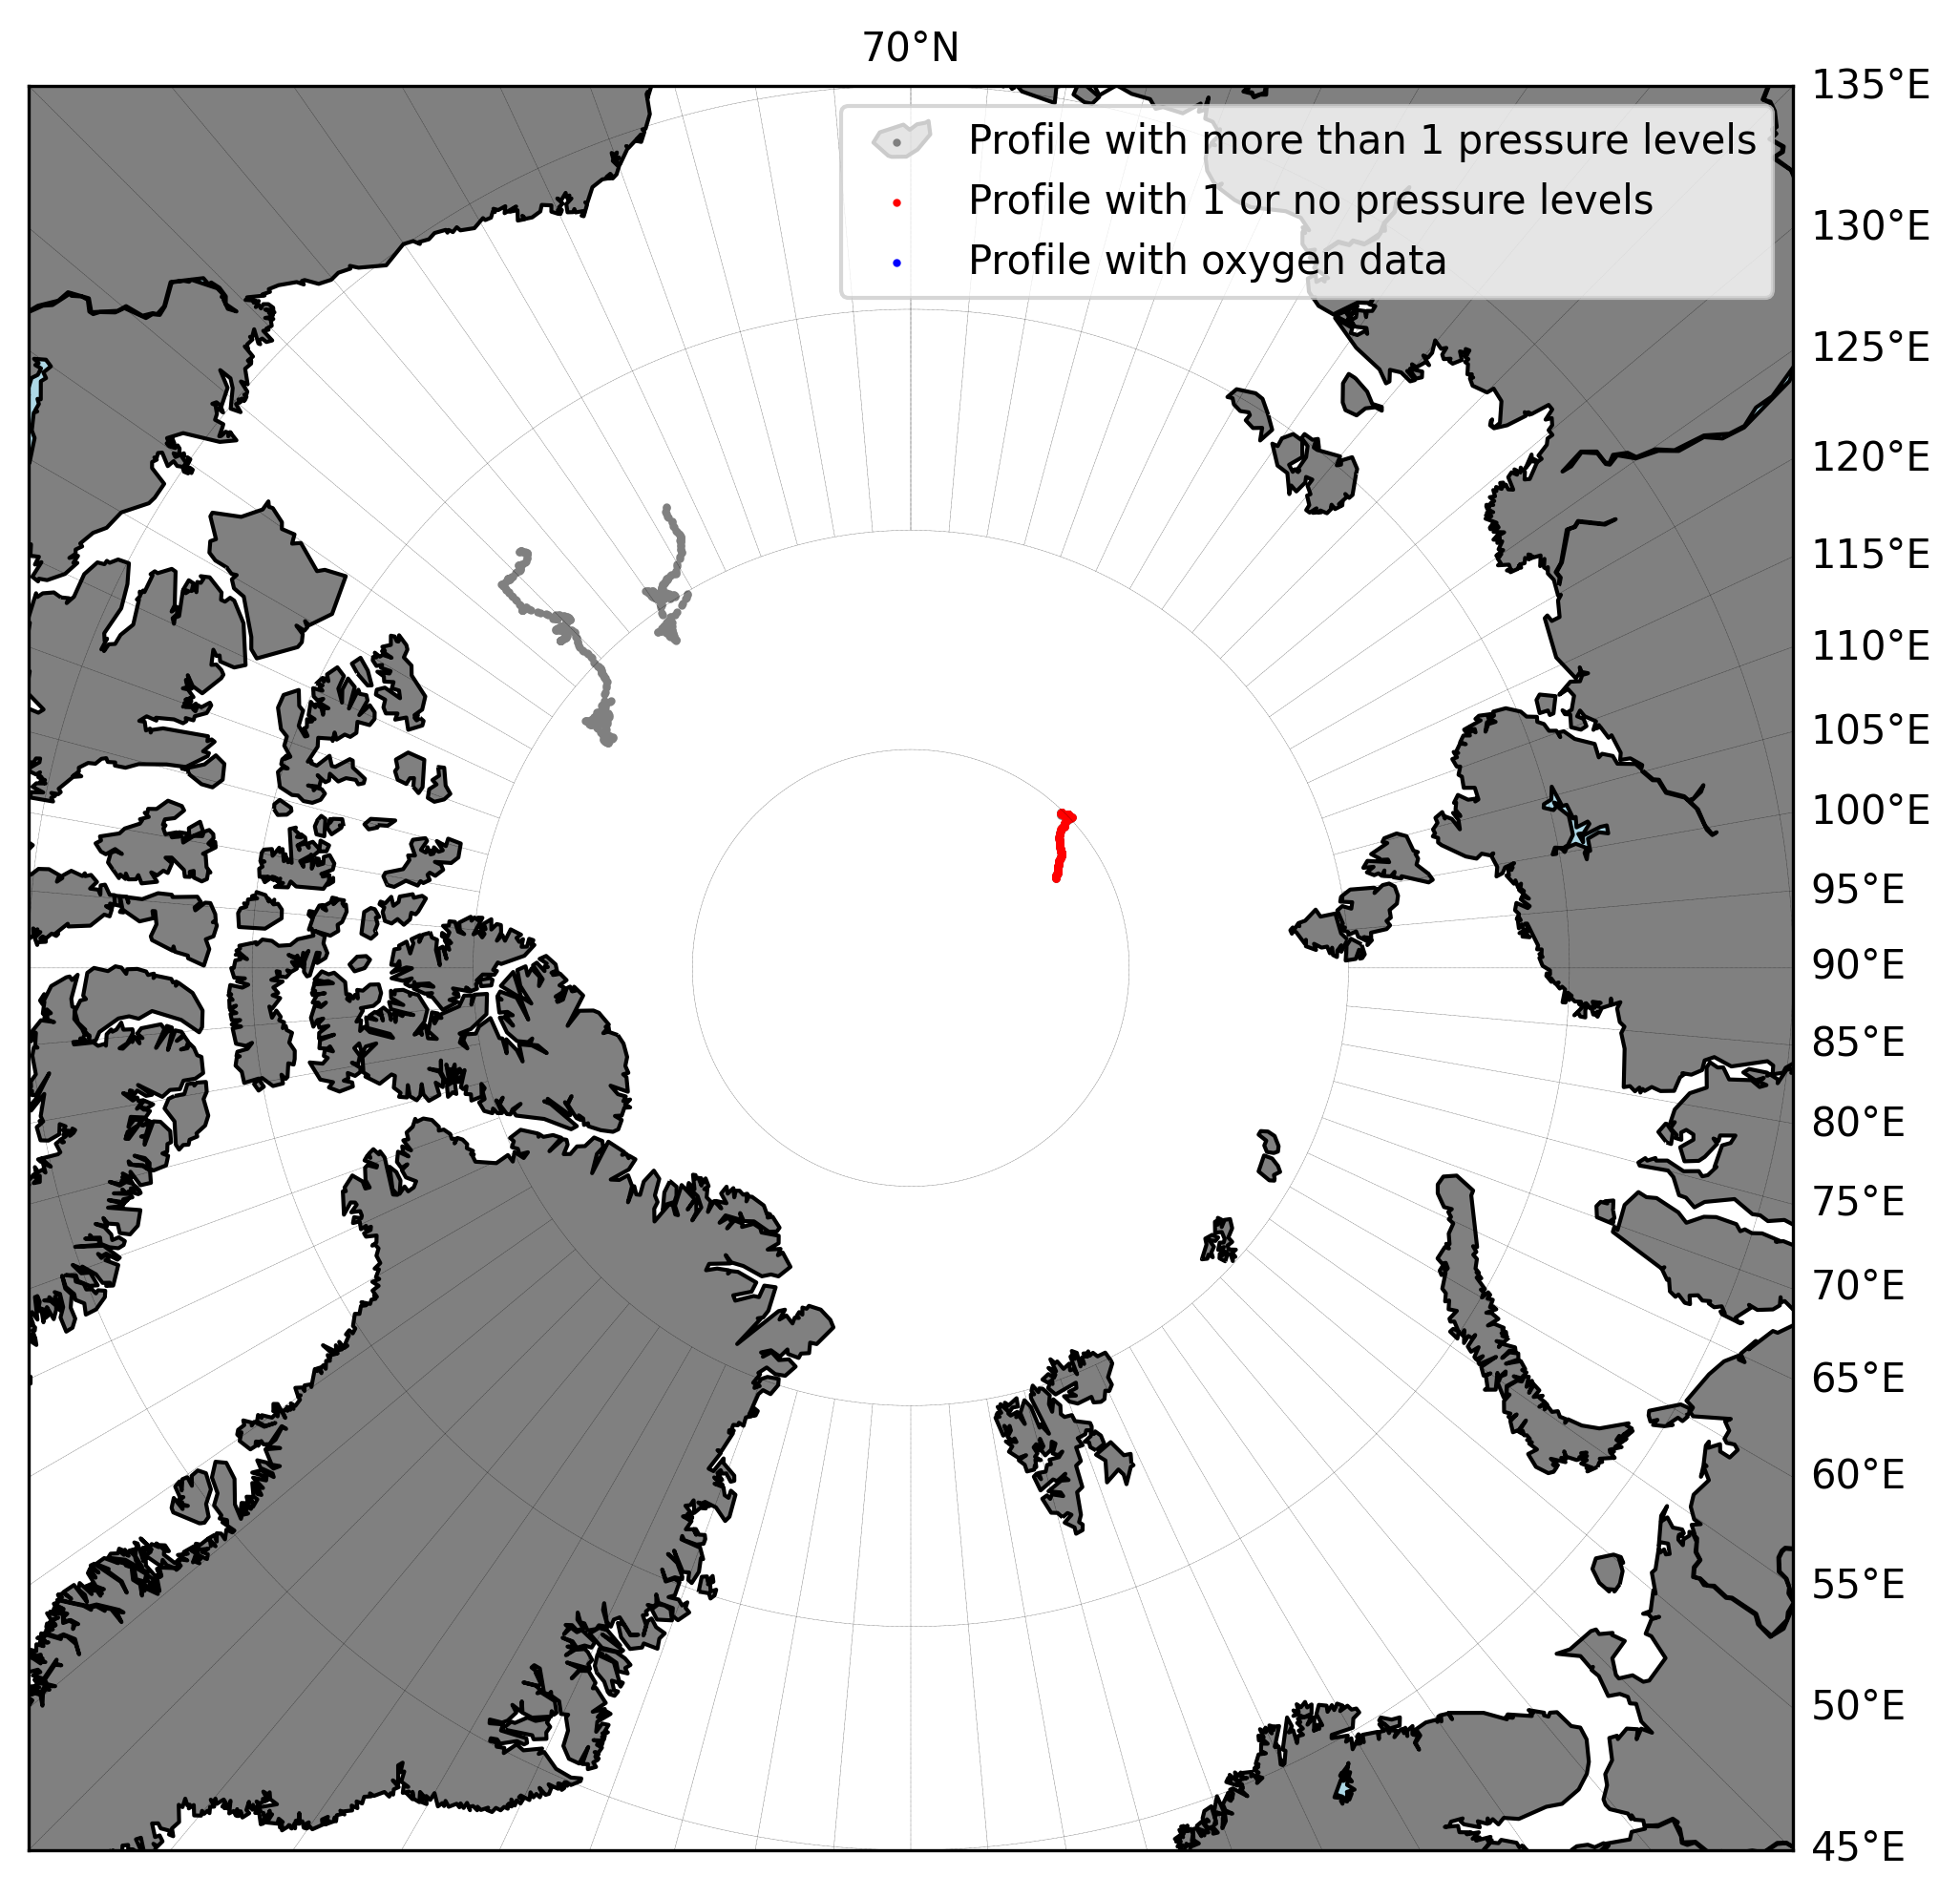

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Define the map bounds and resolution
lon_min, lon_max = -180, 180
lat_min, lat_max = 70, 90
latlon_step = 5
resolution = 'l'  # l for low resolution, h for high resolution

# Set up the figure and the Basemap instance
fig = plt.figure(figsize=(8,8),dpi=300)
m = Basemap(projection='npstere', boundinglat=lat_min, lon_0=0, resolution=resolution)

parallels = np.arange(lat_min, lat_max+1, 5)
meridians = np.arange(lon_min, lon_max+1, 5)

# m.drawparallels(parallels, labels=[True, False, False, False], linewidth=0.1)
# m.drawmeridians(meridians, labels=[False, False, False, True], linewidth=0.1)

m.drawparallels(np.arange(lat_min, lat_max+1, latlon_step), labels=[False,False,True,False], linewidth=0.1)
m.drawmeridians(np.arange(lon_min, lon_max+1, latlon_step), labels=[False,True,False,False], linewidth=0.1)


m.drawcoastlines()
m.fillcontinents(color='grey',lake_color='lightblue')

# plot lat lon distribution of the data with pressure length larger than 1
x, y = m(df.lon[df.larger_1==1].values, df.lat[df.larger_1==1].values)
m.scatter(x, y, 1, marker='o', color='grey',label='Profile with more than 1 pressure levels')

# plot lat lon distribution of the data with pressure length smaller than 1
x, y = m(df.lon[df.larger_1==0].values, df.lat[df.larger_1==0].values)
m.scatter(x, y, 1, marker='o', color='r',label='Profile with 1 or no pressure levels')

# plot lat lon distribution of the data with oxygen data
x, y = m(df.lon[df.is_oxy==1].values, df.lat[df.is_oxy==1].values)
m.scatter(x, y, 1, marker='o', color='b',label='Profile with oxygen data')

# plot the legend on top right
plt.legend(loc='upper right')

# Show the plot
plt.show()


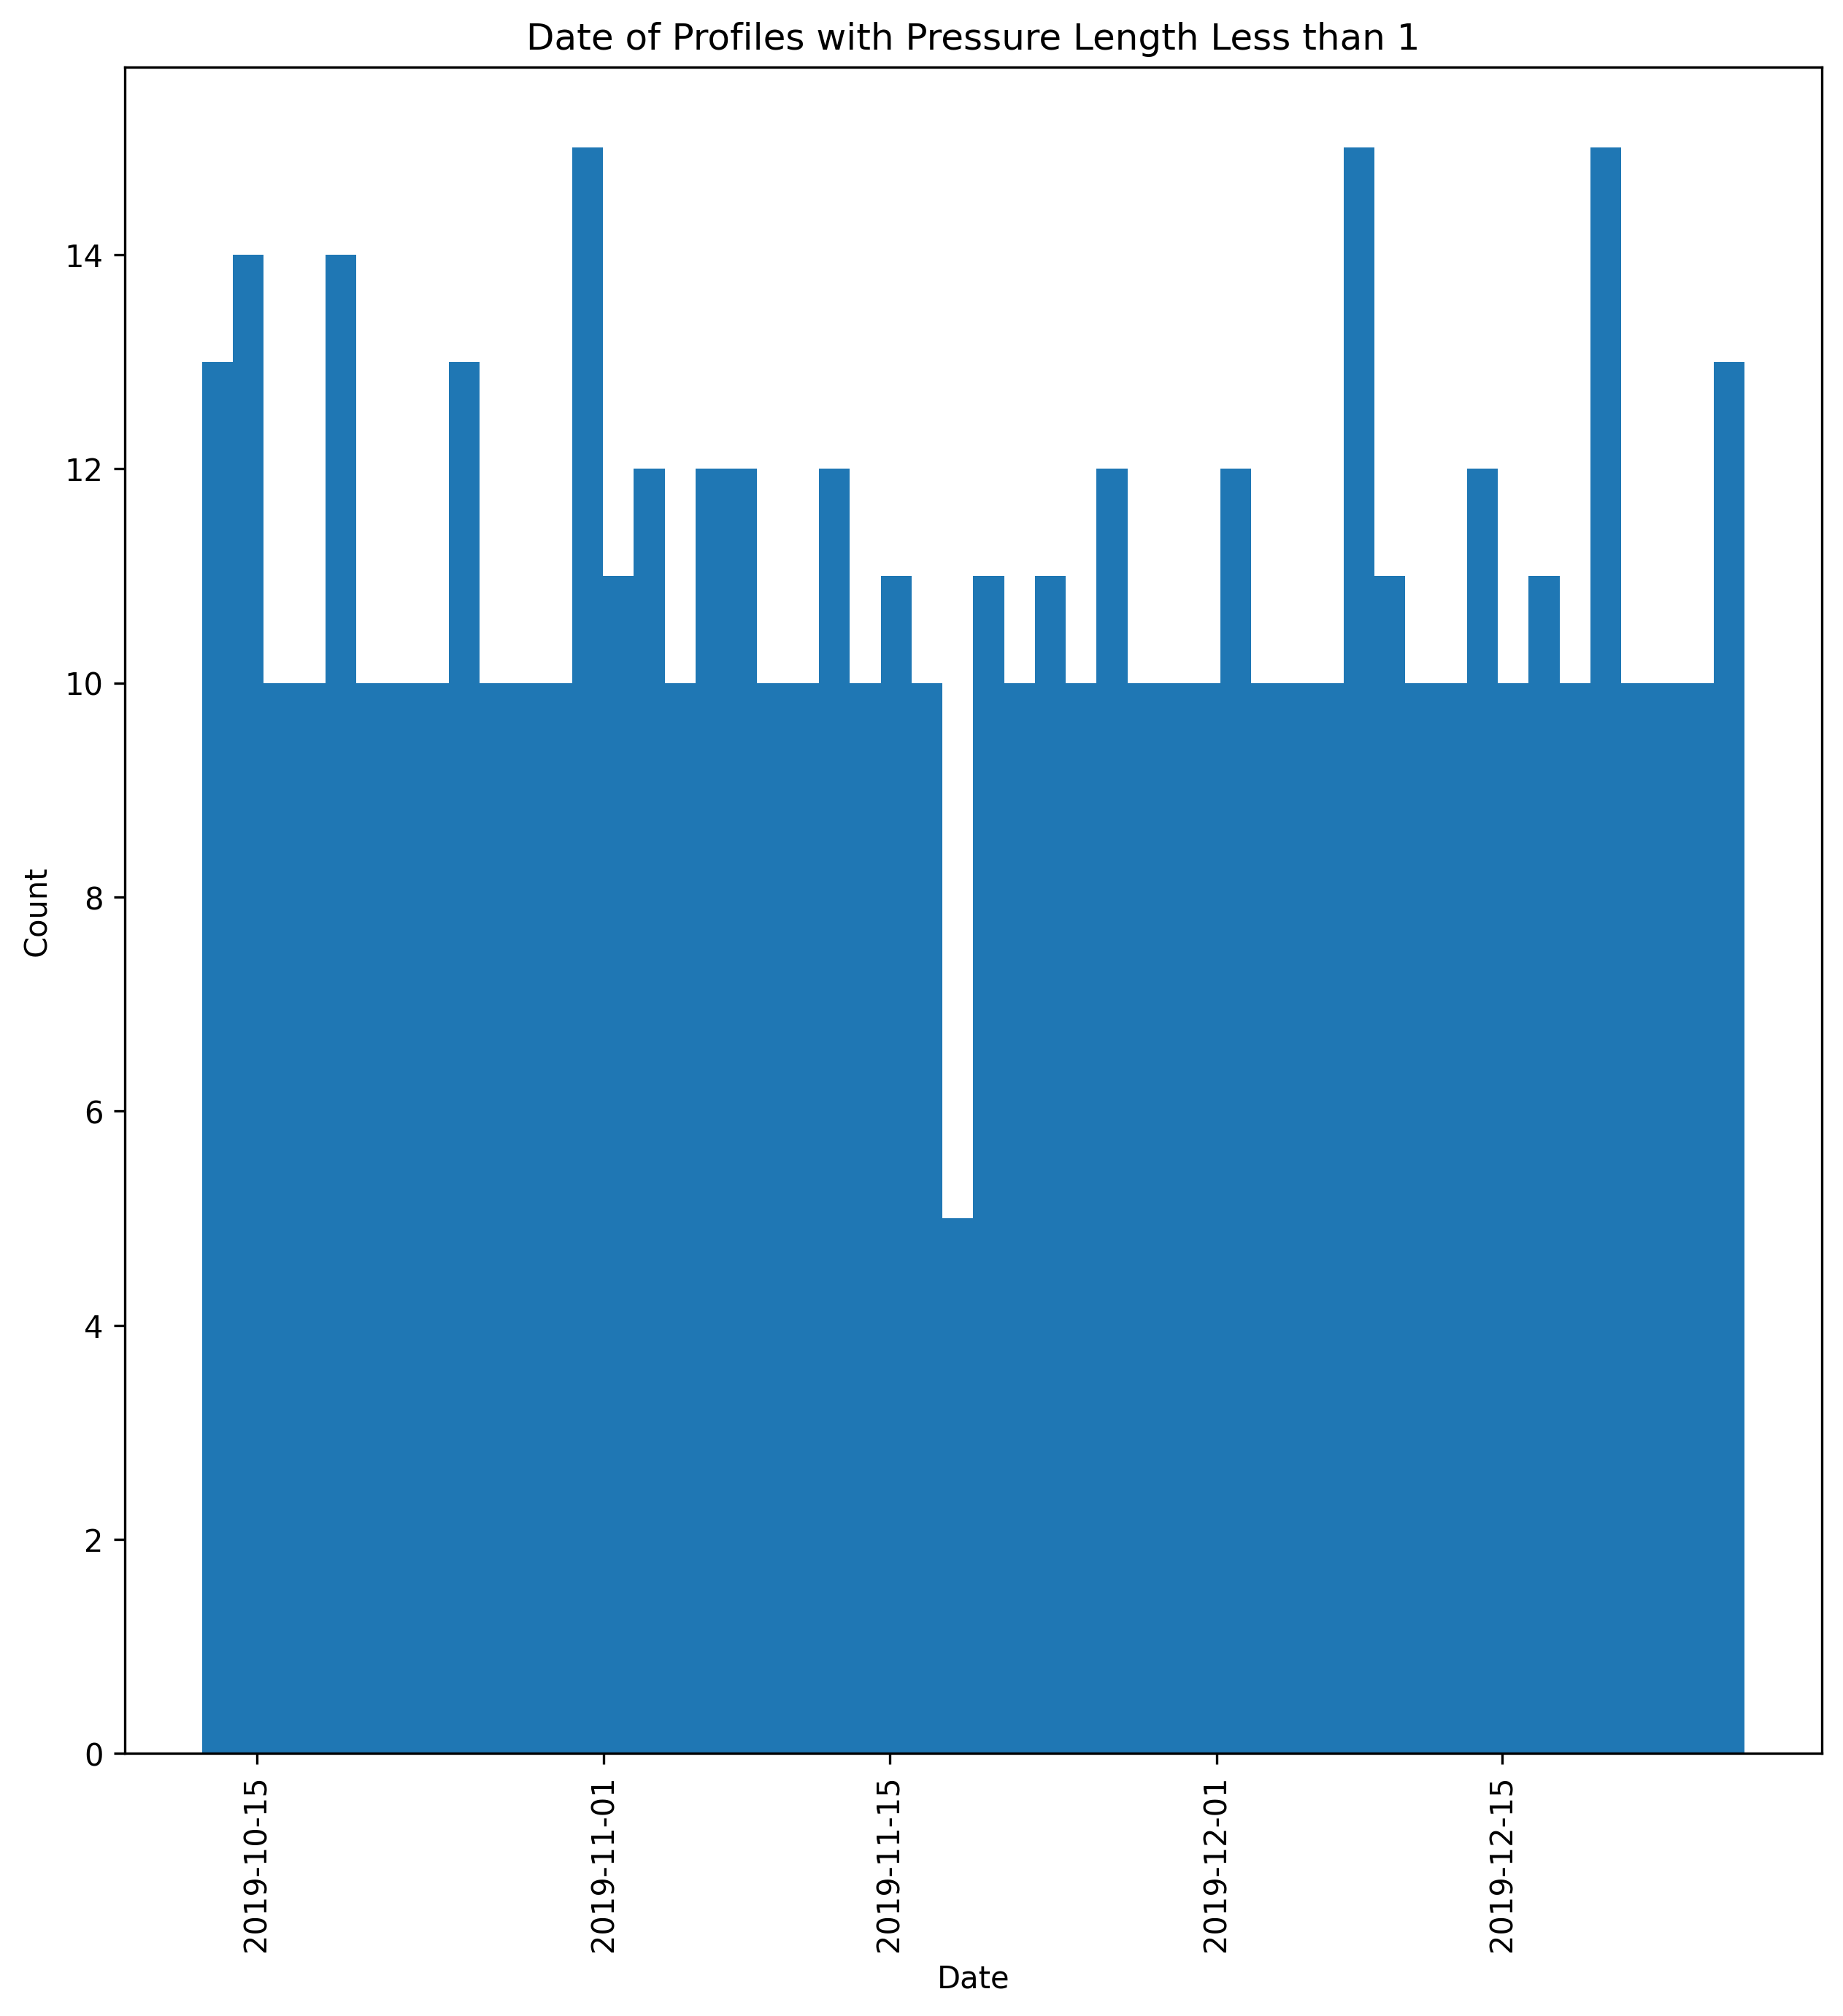

In [47]:
# if there are profiles with pressure length less than 1, plot a histogram of the date of those profiles
if len(df[df.larger_1 ==0]) > 0:
    plt.figure(figsize=(10, 10),dpi=300)
    plt.hist(df[df.larger_1 ==0].date, bins=50)
    plt.title('Date of Profiles with Pressure Length Less than 1')
    plt.xticks(rotation=90)  # rotate xtick labels 90 degrees
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.show()


In [7]:
import pandas as pd
import numpy as np
import xarray as xr

# create a pandas dataframe to store the data
df = pd.DataFrame(columns=['profiler', 'right_format','larger_1','date', 'lon', 'lat', 'p_start','p_end','p_len', 'if_oxy', 'oxy_len'])

import glob
files = glob.glob(f'{data_path}/*.dat')

counter=0
for file in files:
    with open(file) as infile:
        metadata_names=infile.readline()
        metadata_vals=infile.readline().split()
    df.profile = metadata_names.split(':')[0].split(',')[0].split(' ')[1]
    if metadata_vals[-1].isnumeric():
        df.right_format = 1
        if int(metadata_vals[-1])>1:
            df.larger_1 = 1
            ind=pd.read_csv(file,sep='\s+',header=2,engine='python',skipfooter=1,index_col=0)
            try:
                ds=ind.to_xarray().rename({'%pressure(dbar)':'pressure','temperature(C)':'temperature'})
                ds = xr.Dataset({'pressure': ds['pressure'],'temperature': ds['temperature'],'salinity':ds['salinity']})
            except ValueError:
                print('cannot convert to xarray')

            ds=ds.assign_coords({'profiler':int(metadata_names.split(':')[0].split(',')[0].split(' ')[1]),
                                 'date':np.datetime64(pd.Timestamp(metadata_vals[0])+pd.Timedelta(float(metadata_vals[1]),'D')),
                                  'lon':float(metadata_vals[2]),
                                  'lat':float(metadata_vals[3])}
                                 )
            ds=ds.drop_duplicates('pressure',keep='last')
             
        else:
            df.larger_1 = 0
    else:
        df.right_format = 0
        
    counter=counter+1
    if counter==10:
        break



In [8]:
df

,profiler,right_format,larger_1,date,lon,lat,p_start,p_end,p_len,if_oxy,oxy_len


In [6]:
import glob
files = glob.glob(f'{data_path}/*.dat')

df = drop_file_info(files[0])
df




,profiler,right_format,date,lon,lat,p_start,p_end,p_len,if_oxy,oxy_len


In [ ]:
# # Define a function to process individual files
# import pandas as pd
# import xarray as xr
# import numpy as np

# def process_file(file,f_interp,plevels,f_dxoy):
#     with open(file) as infile:
#         metadata_names=infile.readline()
#         metadata_vals=infile.readline().split()

#     if metadata_vals[-1].isnumeric():
#         if int(metadata_vals[-1])>1:
#             ind=pd.read_csv(file,sep='\s+',header=2,engine='python',skipfooter=1,index_col=0)
#             try:
#                 ds=ind.to_xarray().rename({'%pressure(dbar)':'pressure','temperature(C)':'temperature'})
#                 ds = xr.Dataset({'pressure': ds['pressure'],'temperature': ds['temperature'],'salinity':ds['salinity']})
#             except ValueError:
#                 return None

#             ds=ds.assign_coords({'profiler':int(metadata_names.split(':')[0].split(',')[0].split(' ')[1]),
#                                  'date':np.datetime64(pd.Timestamp(metadata_vals[0])+pd.Timedelta(float(metadata_vals[1]),'D')),
#                                   'lon':float(metadata_vals[2]),
#                                   'lat':float(metadata_vals[3])}
#                                  )
#             ds=ds.drop_duplicates('pressure',keep='last')
#             if not f_dxoy: 
#                 if 'dissolved_oxygen' in ds:
#                     ds=ds.drop('dissolved_oxygen')
#             else:
#                 return ds
#             if ds.pressure.size>1:    #ds['pressure'][-1].values>pend:
#                 return ds.interp({'pressure':plevels},assume_sorted=True) # interpolate the pressure levels
#             else:
#                 return None
       
#         else:
#             return None
#     else:
#         return None

In [68]:
# Define a function to process individual files
import pandas as pd
import xarray as xr
import numpy as np

def process_file(file,f_interp,plevels,f_dxoy):
    with open(file) as infile:
        metadata_names=infile.readline()
        metadata_vals=infile.readline().split()

    if metadata_vals[-1].isnumeric():
        if int(metadata_vals[-1])>1:
            ind=pd.read_csv(file,sep='\s+',header=2,engine='python',skipfooter=1,index_col=0)
            try:
                ds=ind.to_xarray().rename({'%pressure(dbar)':'pressure','temperature(C)':'temperature'})
                ds = xr.Dataset({'pressure': ds['pressure'],'temperature': ds['temperature'],'salinity':ds['salinity']})
            except ValueError:
                return None

            ds=ds.assign_coords({'profiler':int(metadata_names.split(':')[0].split(',')[0].split(' ')[1]),
                                 'date':np.datetime64(pd.Timestamp(metadata_vals[0])+pd.Timedelta(float(metadata_vals[1]),'D')),
                                  'lon':float(metadata_vals[2]),
                                  'lat':float(metadata_vals[3])}
                                 )
            ds=ds.drop_duplicates('pressure',keep='last')
            if not f_dxoy: 
                if 'dissolved_oxygen' in ds:
                    ds=ds.drop('dissolved_oxygen')
            # else:
            #     if 'dissolved_oxygen' in ds:
            #         return ds
            if f_interp:
                if ds.pressure.size>1:    #ds['pressure'][-1].values>pend:
                    return ds.interp({'pressure':plevels},assume_sorted=True) # interpolate the pressure levels
                else:
                    return None
            else:
                return ds
        else:
            return None
    else:
        return None

In [74]:
pstart=10
pend=750.
plevels=np.arange(pstart,pend,5.)
files = glob.glob(f'{data_path}/*.dat')

ds = process_file(files[700], True,plevels,True)
ds

<xarray.Dataset>
Dimensions:      (pressure: 148)
Coordinates:
    profiler     int32 102
    date         datetime64[ns] 2019-10-19T12:02:02.688000
    lon          float64 133.3
    lat          float64 85.03
  * pressure     (pressure) float64 10.0 15.0 20.0 25.0 ... 735.0 740.0 745.0
Data variables:
    temperature  (pressure) float64 -1.784 -1.784 -1.784 -1.784 ... nan nan nan
    salinity     (pressure) float64 32.47 32.47 32.47 32.47 ... nan nan nan nan

In [79]:
import glob
import numpy as np
import pandas as pd
import xarray as xr

files = glob.glob(f'{data_path}/*.dat')
print(f'Total {len(files)} files found.')

pstart=10
pend=750.
plevels=np.arange(pstart,pend,5.)

# define a list to hold the individual xarray datasets
datasets = []

counter=0

for file in files:
    ds = process_file(file, True,plevels,True)
    if ds is not None:
        datasets.append(ds)
        counter=counter+1
        if counter==1000:
            # print(datasets)
            break # <-- this line breaks the loop after the first dataset is processed



Total 106013 files found.


In [80]:
# # concatenate the individual xarray datasets into a single xarray dataset
ds_all = xr.concat(datasets, dim='nprof')
ds_all


<xarray.Dataset>
Dimensions:      (nprof: 1000, pressure: 148)
Coordinates:
    profiler     (nprof) int32 100 100 100 100 100 100 ... 102 102 102 102 102
    date         (nprof) datetime64[ns] 2017-09-20T00:02:04.416000 ... 2019-1...
    lon          (nprof) float64 -149.2 -149.1 -148.8 ... 122.4 122.2 122.2
    lat          (nprof) float64 80.04 80.07 80.1 80.12 ... 86.21 86.2 86.2
  * pressure     (pressure) float64 10.0 15.0 20.0 25.0 ... 735.0 740.0 745.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 -1.495 -1.495 -1.342 ... nan nan nan
    salinity     (nprof, pressure) float64 27.8 27.81 28.08 ... nan nan nan

In [55]:
ds_all['temperature'][1].pressure

<xarray.DataArray 'pressure' (pressure: 1256)>
array([  8.4,   8.9,  10. , ..., 787. , 788. , 789. ])
Coordinates:
  * pressure  (pressure) float64 8.4 8.9 10.0 11.0 ... 786.0 787.0 788.0 789.0
    profiler  int32 100
    date      datetime64[ns] 2017-09-20T06:02:01.824000
    lon       float64 -149.1
    lat       float64 80.07

In [10]:
import glob
import numpy as np
import pandas as pd
import xarray as xr

files = glob.glob(f'{data_path}/*.dat')
print(f'Total {len(files)} files found.')

pstart=10
pend=750.
plevels=np.arange(pstart,pend,5.)

# define a list to hold the individual xarray datasets
def process_all_files(files,f_interp,plevels,f_dxoy):
    datasets = []
    counter=0
    # loop through files and process each one
    for file in files:
        ds = process_file(file, f_interp,plevels,f_dxoy)
        if ds is not None:
            datasets.append(ds)
            counter=counter+1
            if counter==10:
                break

    print(f'{counter} files processed.')
    ds_all = xr.concat(datasets, dim='nprof')
    return ds_all


Total 106013 files found.


In [ ]:
ds_all_no_oxy_interp = process_all_files(files, True,plevels,False)

In [11]:
ds_all_no_oxy_no_interp = process_all_files(files, False,plevels,False)

KeyboardInterrupt: 

In [2]:
# # Define a function to process individual files
# import pandas as pd
# import xarray as xr
# import numpy as np

# def process_file(file,plevels):
#     with open(file) as infile:
#         metadata_names=infile.readline()
#         metadata_vals=infile.readline().split()

#     if metadata_vals[-1].isnumeric():
#         if int(metadata_vals[-1])>1:
#             ind=pd.read_csv(file,sep='\s+',header=2,engine='python',skipfooter=1,index_col=0)
#             try:
#                 ds=ind.to_xarray().rename({'%pressure(dbar)':'pressure','temperature(C)':'temperature'})
#                 ds = xr.Dataset({'pressure': ds['pressure'],'temperature': ds['temperature'],'salinity':ds['salinity']})
#             except ValueError:
#                 return None

#             ds=ds.assign_coords({'profiler':int(metadata_names.split(':')[0].split(',')[0].split(' ')[1]),
#                                  'date':np.datetime64(pd.Timestamp(metadata_vals[0])+pd.Timedelta(float(metadata_vals[1]),'D')),
#                                   'lon':float(metadata_vals[2]),
#                                   'lat':float(metadata_vals[3])}
#                                  )
#             ds=ds.drop_duplicates('pressure',keep='last')
#             if 'dissolved_oxygen' in ds:
#                 ds=ds.drop('dissolved_oxygen')
#             if ds.pressure.size>1:    #ds['pressure'][-1].values>pend:
#                 return ds.interp({'pressure':plevels},assume_sorted=True) # interpolate the pressure levels
#             else:
#                 return None
#         else:
#             return None
#     else:
#         return None

In [10]:
import glob
import numpy as np
import pandas as pd
import xarray as xr

files = glob.glob(f'{data_path}/*.dat')
print(f'Total {len(files)} files found.')

pstart=10
pend=750.
plevels=np.arange(pstart,pend,5.)

# define a list to hold the individual xarray datasets
datasets = []

counter=0
# loop through files and process each one
for file in files:
    ds = process_file(file, plevels)
    if ds is not None:
        datasets.append(ds)
        # counter=counter+1
        # if counter==100:
        #     break

# concatenate the individual xarray datasets into a single xarray dataset
ds_all = xr.concat(datasets, dim='nprof')

Total 106013 files found.


In [11]:
ds_all

<xarray.Dataset>
Dimensions:      (nprof: 88774, pressure: 148)
Coordinates:
    profiler     (nprof) int32 100 100 100 100 100 100 100 100 ... 9 9 9 9 9 9 9
    date         (nprof) datetime64[ns] 2017-09-20T00:02:04.416000 ... 2009-0...
    lon          (nprof) float64 -149.2 -149.1 -148.8 ... -95.51 -95.29 -95.09
    lat          (nprof) float64 80.04 80.07 80.1 80.12 ... 82.75 82.76 82.76
  * pressure     (pressure) float64 10.0 15.0 20.0 25.0 ... 735.0 740.0 745.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 -1.495 -1.495 -1.342 ... 0.231 0.2258
    salinity     (nprof, pressure) float64 27.8 27.81 28.08 ... 34.88 34.88

In [1]:
# save the xarry to local file
ds_all.to_netcdf(f"{data_path}/ds_all.nc")

NameError: name 'ds_all' is not defined

In [3]:
# read the xarray from local file
import xarray as xr
ds_all=xr.open_dataset(f"{data_path}/ds_all.nc")
ds_all['pressure']=-ds_all['pressure']
ds_all

<xarray.Dataset>
Dimensions:      (nprof: 88774, pressure: 148)
Coordinates:
    profiler     (nprof) int32 ...
    date         (nprof) datetime64[ns] ...
    lon          (nprof) float64 ...
    lat          (nprof) float64 ...
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -735.0 -740.0 -745.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 ...
    salinity     (nprof, pressure) float64 ...

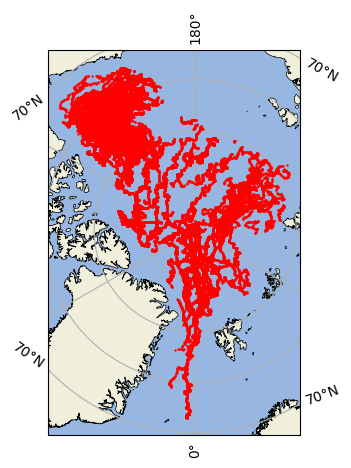

In [5]:
# plot the locations of all data
import plot_toolbox as ptb
ptb.plot_data_location(ds_all,dpi=100)

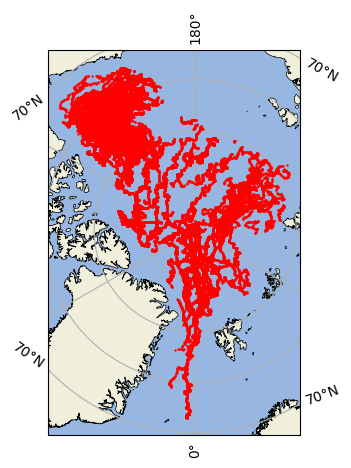

In [6]:
# remove the data with lat<60
ds_all=ds_all.where(ds_all.lat>60,drop=True)
ptb.plot_data_location(ds_all,dpi=100)

In [7]:
ds_all

<xarray.Dataset>
Dimensions:      (nprof: 88492, pressure: 148)
Coordinates:
    profiler     (nprof) int32 100 100 100 100 100 100 100 100 ... 9 9 9 9 9 9 9
    date         (nprof) datetime64[ns] 2017-09-20T00:02:04.416000 ... 2009-0...
    lon          (nprof) float64 -149.2 -149.1 -148.8 ... -95.51 -95.29 -95.09
    lat          (nprof) float64 80.04 80.07 80.1 80.12 ... 82.75 82.76 82.76
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -735.0 -740.0 -745.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 -1.495 -1.495 -1.342 ... 0.231 0.2258
    salinity     (nprof, pressure) float64 27.8 27.81 28.08 ... 34.88 34.88

In [14]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

pstart1 = np.arange(-10, -345, -10)
pend1 = -370

# store the size of the dataset after each iteration
nprof_size1 = []

for p in pstart1:
    ds_cleaned = ds_all.sel(pressure=slice(p, pend1)).dropna('nprof')
    nprof_size1.append(ds_cleaned.nprof.size)

pstart2 = -370.
pend2 = np.arange(-400, -745, -10)

# store the size of the dataset after each iteration
nprof_size2 = []

for p in pend2:
    ds_cleaned = ds_all.sel(pressure=slice(pstart2, p)).dropna('nprof')
    nprof_size2.append(ds_cleaned.nprof.size)

# plot the size vs pend
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Scatter(x=pstart1, y=nprof_size1, mode='markers'), row=1, col=1)
fig.update_xaxes(title_text="pstart", row=1, col=1, autorange="reversed")
fig.update_yaxes(title_text="Size", row=1, col=1)
fig.update_layout(title='pstart versus record size')

fig.add_trace(go.Scatter(x=pend2, y=nprof_size2, mode='markers'), row=1, col=2)
fig.update_xaxes(title_text="Pend", row=1, col=2, autorange="reversed")
fig.update_yaxes(title_text="Size", row=1, col=2)
fig.update_layout(title='start and end pressure versus record size')

fig.show()


In [121]:
# select a pressure range
pstart=-10.
pend=-500.

ds_cleaned=ds_all.sel(pressure=slice(pstart,pend)).dropna('nprof')
ds_cleaned

<xarray.Dataset>
Dimensions:      (nprof: 47890, pressure: 99)
Coordinates:
    profiler     (nprof) int32 100 100 100 100 100 100 100 100 ... 9 9 9 9 9 9 9
    date         (nprof) datetime64[ns] 2017-09-20T00:02:04.416000 ... 2009-0...
    lon          (nprof) float64 -149.2 -148.8 -148.0 ... -97.41 -95.51 -95.29
    lat          (nprof) float64 80.04 80.1 80.18 80.28 ... 82.65 82.75 82.76
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -490.0 -495.0 -500.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 -1.495 -1.495 -1.342 ... 0.422 0.4203
    salinity     (nprof, pressure) float64 27.8 27.81 28.08 ... 34.84 34.84

In [122]:
# save the cleaned xarry to local file
ds_cleaned.to_netcdf(f"{data_path}/ds_cleaned.nc")

In [123]:
# read the cleaned xarray from local file
import xarray as xr
ds_cleaned=xr.open_dataset(f"{data_path}/ds_cleaned.nc")

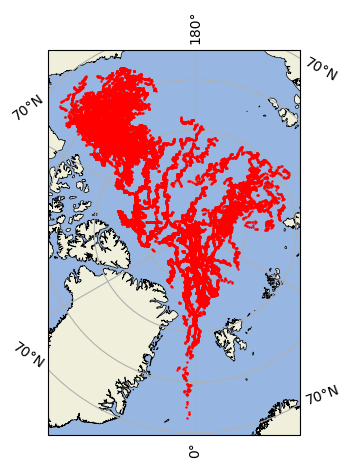

In [124]:
# plot the locations of cleaned data
import plot_toolbox as ptb
ptb.plot_data_location(ds_cleaned,dpi=100)